In [19]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox

sns.set(style="ticks", color_codes=True)

%matplotlib inline

# Introduction

Using seasonally-aggregated input data generated in notebook 01_generate_features, carry out exploratory data analysis to help identify potentially important relationships. This includes:

* Time series of potentially important explanatory variables
* Correlation coefficients
* Scatterplot matrices

Data matrices for each of the four target variables (lake TP, chl-a, cyanobacteria and colour) are written to csv for use in the feature importance analysis.

Used to inform the selection of variables to include in the GBN (together with feature importance analysis and process knowledge).

Created by Leah JB. Part of the ERA4CS WATExR project.

# User input

In [20]:
# User input
met_source = "metno"  # Only choice available here

# File paths to input data
seasonal_features_fpath = (
    r"../Data/DataMatrices/Seasonal_6monthly/Vansjø_seasonal_data_1Season_Van2_%s.csv"
    % met_source
)
# Paths to folders for saving output

# Folder to write csvs for use in feature importance analysis
out_folder = r"../Data/DataMatrices/Seasonal_6monthly/split_by_variable"

# Correlation coefficients
corr_coeff_folder = r"../Data/CorrelationCoeffs"

# Graphs
graph_outfolder = r"../Figures"

# Read in seasonally-aggregated data

In [21]:
season_df = pd.read_csv(seasonal_features_fpath, index_col=0, parse_dates=True)
season_df.head()

,Pptn,Temp,Wind_speed,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,CyanoBiovol,Rain_day,...,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,TP_lake_prevSummer,colour_lake_prevSummer,chl-a_lake_prevSummer,Temp_prevSummer,CyanoBiovol_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-04-30,NaN,-2.949842,2.856667,NaN,130.0,3.971429,45.250000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-10-31,579.570268,13.006020,3.324457,87.603466,86.4,16.080130,43.573016,NaN,NaN,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-04-30,244.713839,-0.844447,3.432044,69.390950,NaN,NaN,NaN,NaN,NaN,39.0,...,16.0,34.0,81.0,56.0,27.0,43.573016,NaN,16.08013,13.006020,NaN
1981-10-31,494.520283,12.574081,3.479891,61.606742,NaN,8.331250,28.833333,NaN,NaN,61.0,...,5.0,40.0,67.0,65.0,38.0,43.573016,NaN,16.08013,13.006020,NaN
1982-04-30,371.084444,-1.856862,3.383978,96.553901,69.0,1.100000,46.250000,NaN,NaN,61.0,...,17.0,30.0,69.0,67.0,35.0,28.833333,NaN,8.33125,12.574081,NaN


Note that the number of samples per month was low until 2005, so the monthly and seasonal means based on them are much less accurate. Much more intense sampling from 2005 until 2012. Any way of giving these seasons higher weight when fitting the BN I wonder?

As a result of this, the apparently high monthly mean chl-a in 2004, which is a real outlier, looks a bit suspicious as it's only based on 3 data points. Compared to around 8 in 2005, maybe more.

The imbalance in the number of samples per year for lake colour is particularly massive, due partly to the patching of the two different data sources (MOVAR vs. NIVA). Apparent trends over time could easily be due to changes in sampling frequency.

# Time series plots

## Summer growing season time series

In [22]:
# vars to keep and plot (aside from Season)
vars_to_plot = [
    'TP_lake',
    'chl-a_lake',
    'CyanoBiovol',
    'colour_lake',
    'Pptn',
    'Wind_speed',
    'Temp',
    'Q',
    'TP_catch',
    ]

# Select data to be plotted
df_plot = season_df.loc[:, vars_to_plot+['Season']]  # Drop all but variables to keep
df_plot = df_plot.loc[df_plot['Season'] == 'summ', ~df_plot.columns.isin(['season'])]

# Add year column and reindex using year
df_plot['year'] = df_plot.index.year
df_plot.set_index('year', inplace=True)

df_plot.tail()

,TP_lake,chl-a_lake,CyanoBiovol,colour_lake,Pptn,Wind_speed,Temp,Q,TP_catch,Season
year,,,,,,,,,,
2014,20.300000,12.600000,0.283,41.863636,633.603979,3.508840,14.482813,74.580394,79.400000,summ
2015,24.250000,14.925000,0.233,52.833333,684.936515,3.769022,12.708488,84.946320,81.000000,summ
2016,18.750000,9.590909,0.166,52.000000,396.823713,3.751630,14.037478,19.828454,63.615385,summ
2017,19.666667,12.866667,0.258,42.000000,570.221295,3.705435,13.359368,68.075251,77.928571,summ
2018,18.666667,10.741667,0.614,36.333333,300.208553,3.959783,15.439945,10.345450,NaN,summ


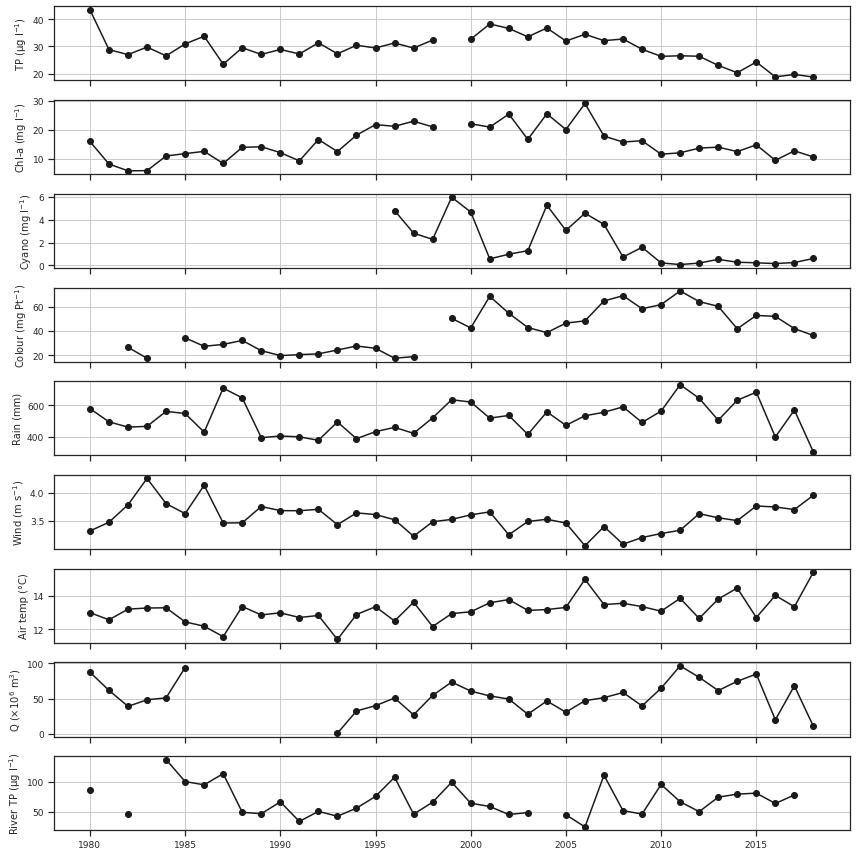

In [23]:
# Dictionary for renaming variable names
label_dict = {
    "chl-a_lake": "Chl-a (mg l$^{-1}$)",
    "colour_lake": "Colour (mg Pt$^{-1}$)",
    "CyanoBiovol": "Cyano (mg l$^{-1}$)",
    "Pptn": "Rain (mm)",
    "Temp": "Air temp (°C)",
    "TP_lake": "TP (µg l$^{-1}$)",
    "Wind_speed": "Wind (m s$^{-1}$)",
    "Season": "Season",
    "Q": "Q (×10$^6$ m$^3$)",
    "TP_catch": "River TP (µg l$^{-1}$)",
}

ax = df_plot.plot(
    subplots=True, figsize=(12, 12), grid=True, marker="o", legend=False, color="k"
)
for i, var in enumerate(vars_to_plot):
    ax[i].xaxis.grid(True, which="minor", linestyle="-", linewidth=0.5)
    ax[i].set_ylabel(label_dict[var], fontsize=10)
    ax[i].set_xlabel("")
    ax[i].tick_params(axis="both", which="major", labelsize=9)

plt.tight_layout()
plt.savefig(
    os.path.join(
        graph_outfolder,
        "Timeseries_seasonal_interesting_vars",
        "Vansjø_6M_timeseries_forPaper_%s.png" % met_source,
    )
)
plt.savefig(
    os.path.join(
        graph_outfolder,
        "Timeseries_seasonal_interesting_vars",
        "Vansjø_6M_timeseries_forPaper_%s.eps" % met_source,
    )
)

## Summer and winter season time series

In winter 2000-2001 there was a large flood event, widely thought to have caused wash-in of nutrients to the lake, and cyanobacterial blooms and bathing bans for much of the period 2001-2007. However, on the time series plot below, we can see peak precipitation and discharge in winter 2001, but cyanobacteria if anything decreased for a couple of years after the high Q.

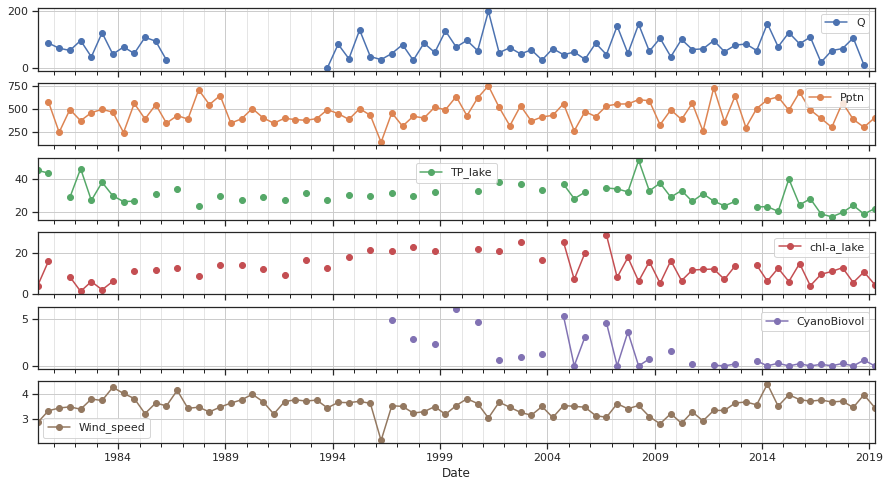

In [24]:
vars_to_plot = ["Q", "Pptn", "TP_lake", "chl-a_lake", "CyanoBiovol", "Wind_speed"]
ax = season_df.loc[:, vars_to_plot].plot(
    subplots=True, figsize=(15, 8), grid=True, marker="o"
)
for i, var in enumerate(vars_to_plot):
    ax[i].xaxis.grid(True, which="minor", linestyle="-", linewidth=0.5)
ax[1].legend(loc="upper right")

# Split into separate matrices for the 4 possible response variables & look at correlations

In [25]:
season_slice = 'summ'  # one of 'all', 'wint', 'summ'
if season_slice in ['wint', 'summ']:
    season_var_df = season_df.loc[season_df['Season'] == season_slice, :]

print(len(season_df))

79


In [26]:
# Plotting function
def plot_scattermatrix(season_df, vars_for_scatterplot, var):
    """
    Custom scattermatrix function.
    Input: df containing data to plot
    vars_for_scatterplot: list of column names from within df that you want to include
    var: dependent variable name, just used for file naming
    """

    rename_dict = {
    "TP_lake": "TP",
    "TP_lake_prevSummer": "TP (PS)",
    "Wind_under_Q0.2": "Wind<P20",
    "Wind_speed_lag1": "Wind speed (W)",
    "Wind_speed": "Wind speed",
    "Q": "Q",
    'chl-a_lake': 'Chl-a',
    'chl-a_lake_prevSummer': 'Chl-a (PS)',
    'Wind_over_Q0.6': 'Wind>P60',
    'Temp': 'Temp',
    'CyanoBiovol': 'Cyano',
    'CyanoBiovol_prevSummer': 'Cyano (PS)',
    'colour_lake': 'Colour',
    'Wind_over_Q0.6_lag1': 'Wind>P60 (W)',
    'colour_lake_prevSummer': 'Colour (PS)',
    'Pptn': 'Rain sum',
    'Temp_prevSummer': 'Temp (PS)',
    'cyano_bxcx': 'Cyano (boxcox)'
    }

    figsize = len(vars_for_scatterplot) * 1.5 + 1

    plot_df = season_df.loc[:, vars_for_scatterplot]
    plot_df = plot_df.rename(columns=rename_dict)

    pd.plotting.scatter_matrix(
        plot_df,
        diagonal="kde",
        color="black",
        density_kwds={"color": "black"},
        alpha=0.6,
        s=150,
        figsize=(figsize, figsize),
    )
    plt.tight_layout()

    # Save as png
    fpath = os.path.join(graph_outfolder, "Scatterplots", "seasonal_6M_scattermatrix_%s_%s.png" % (var, met_source))
    plt.savefig(fpath, dpi=300)

    # Save as eps for publishing
    fpath = os.path.join(graph_outfolder, "Scatterplots", "seasonal_6M_scattermatrix_%s_%s.eps" % (var, met_source))
    plt.savefig(fpath)

    plt.show()

In [27]:
sorted(season_df.columns)

['CyanoBiovol',
 'CyanoBiovol_prevSummer',
 'Pptn',
 'Pptn_intense',
 'Pptn_intense_lag1',
 'Pptn_lag1',
 'Q',
 'Q_lag1',
 'Rain_day',
 'Rain_day_lag1',
 'Season',
 'TP_catch',
 'TP_lake',
 'TP_lake_prevSummer',
 'Temp',
 'Temp_lag1',
 'Temp_prevSummer',
 'Temp_subzero',
 'Wind_over_Q0.6',
 'Wind_over_Q0.6_lag1',
 'Wind_over_Q0.8',
 'Wind_over_Q0.8_lag1',
 'Wind_speed',
 'Wind_speed_lag1',
 'Wind_under_Q0.2',
 'Wind_under_Q0.2_lag1',
 'Wind_under_Q0.4',
 'Wind_under_Q0.4_lag1',
 'chl-a_lake',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_prevSummer']

## Lake TP

In [28]:
# First, lake TP concentration is the dependent variable.
cols_to_drop = [
 'CyanoBiovol',
 'CyanoBiovol_prevSummer',
 'chl-a_lake',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_prevSummer',
 'Temp_subzero',
    ]

season_df_TP = season_var_df.drop(cols_to_drop, axis=1)
print(len(season_df_TP))

# Drop any rows where TP_lake is a NaN
season_df_TP.dropna(subset=['TP_lake'], inplace=True)
print(len(season_df_TP))
season_df_TP.head()

39
38


,Pptn,Temp,Wind_speed,Q,TP_catch,TP_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,...,Wind_speed_lag1,Q_lag1,Rain_day_lag1,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,TP_lake_prevSummer,Temp_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-10-31,579.570268,13.006020,3.324457,87.603466,86.400000,43.573016,83.0,16.0,34.0,81.0,...,2.856667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-10-31,494.520283,12.574081,3.479891,61.606742,NaN,28.833333,61.0,17.0,30.0,69.0,...,3.432044,69.390950,39.0,5.0,40.0,67.0,65.0,38.0,43.573016,13.006020
1982-10-31,460.222077,13.213326,3.790761,38.953613,45.500000,26.988095,64.0,18.0,20.0,53.0,...,3.383978,96.553901,61.0,10.0,47.0,81.0,70.0,42.0,28.833333,12.574081
1983-10-31,465.471465,13.281862,4.259239,48.269174,NaN,29.781250,62.0,14.0,13.0,48.0,...,3.732597,124.071782,68.0,14.0,43.0,72.0,77.0,48.0,26.988095,13.213326
1984-10-31,561.657520,13.295250,3.811413,50.983690,137.664286,26.527500,76.0,21.0,9.0,52.0,...,4.012637,73.802189,45.0,5.0,36.0,65.0,89.0,58.0,29.781250,13.281862


In [29]:
X = season_df_TP.drop(['TP_lake'], axis=1)
y = season_df_TP['TP_lake']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_TP_%s.csv' % met_source))

Wind_speed_lag1        -0.407258
Wind_over_Q0.6         -0.352315
Wind_over_Q0.6_lag1    -0.328895
Wind_speed             -0.292963
Wind_over_Q0.8_lag1    -0.249446
Temp_lag1              -0.201778
Wind_over_Q0.8         -0.177144
Temp                   -0.172941
TP_catch               -0.140894
Temp_prevSummer        -0.030969
Q_lag1                 -0.019325
Pptn                    0.015416
Rain_day                0.041222
Rain_day_lag1           0.061902
Pptn_intense            0.073697
Pptn_intense_lag1       0.075585
Q                       0.115209
Pptn_lag1               0.139422
Wind_under_Q0.4_lag1    0.331382
Wind_under_Q0.4         0.382679
Wind_under_Q0.2_lag1    0.449411
Wind_under_Q0.2         0.513811
TP_lake_prevSummer      0.642256
dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


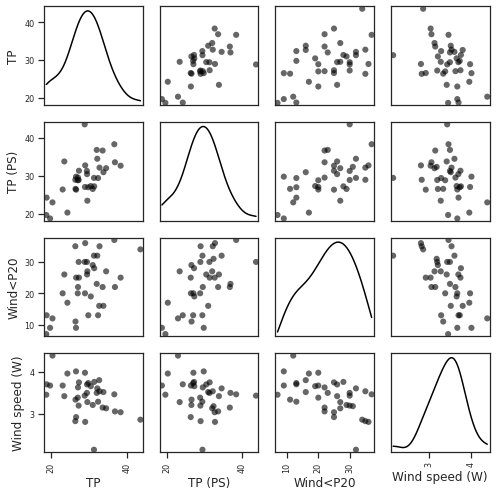

In [30]:
vars_for_scatterplot = [
    "TP_lake",
    "TP_lake_prevSummer",
    "Wind_under_Q0.2",
    "Wind_speed_lag1",
    # "Wind_speed",
    # "Q"
]
plot_scattermatrix(season_var_df, vars_for_scatterplot, 'TP')

## Lake chl-a

In [31]:
# 2) chl-a concentration
cols_to_drop = [
 'CyanoBiovol',
 'CyanoBiovol_prevSummer',
 'Temp_subzero'
    ]

season_df_lake_chla = season_var_df.drop(cols_to_drop,axis=1)
print(len(season_df_lake_chla))

# Drop any rows where explanatory variable value is a NaN
season_df_lake_chla.dropna(subset=['chl-a_lake'], inplace=True)
print(len(season_df_lake_chla))
# monthly_df_lake_chla.head()

39
38


In [32]:
X = season_df_lake_chla.drop(['chl-a_lake'], axis=1)
y = season_df_lake_chla['chl-a_lake']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_chla_%s.csv' % met_source))

Wind_over_Q0.6           -0.507081
Wind_speed               -0.500249
Wind_over_Q0.8           -0.483618
Wind_over_Q0.6_lag1      -0.300783
TP_catch                 -0.288928
Wind_over_Q0.8_lag1      -0.244267
Wind_speed_lag1          -0.234446
Q                        -0.103925
Q_lag1                   -0.050985
Rain_day                 -0.048075
Pptn                      0.007250
Pptn_intense_lag1         0.015823
Pptn_lag1                 0.054245
Rain_day_lag1             0.060759
colour_lake_prevSummer    0.061480
Pptn_intense              0.069785
Temp_prevSummer           0.117496
colour_lake               0.156349
Temp_lag1                 0.157174
Wind_under_Q0.4_lag1      0.163274
Wind_under_Q0.2_lag1      0.168676
Temp                      0.209138
Wind_under_Q0.2           0.291225
TP_lake_prevSummer        0.314764
Wind_under_Q0.4           0.407945
TP_lake                   0.578936
chl-a_lake_prevSummer     0.652900
dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


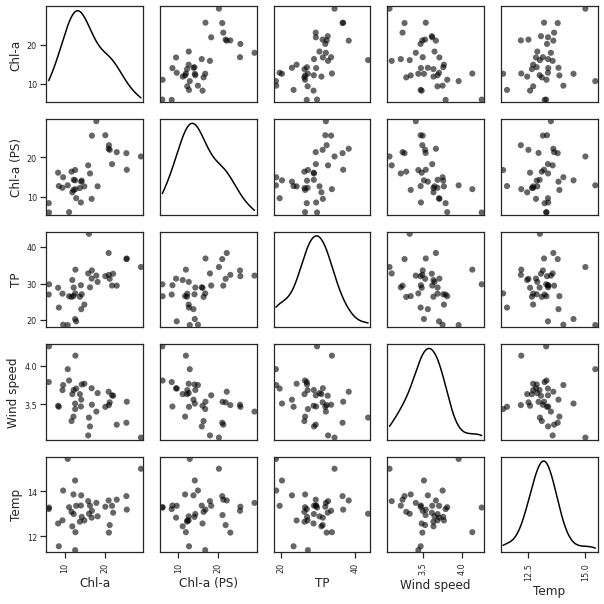

In [33]:
vars_for_scatterplot = ['chl-a_lake',
                        'chl-a_lake_prevSummer',
                        'TP_lake',
                        'Wind_speed',
                        'Temp']

plot_scattermatrix(season_var_df, vars_for_scatterplot, 'chl-a')

## Max cyanobacterial biovolume

In [34]:
# cols to drop:
cols_to_drop = [
 'Temp_subzero'
    ]

season_df_cyano = season_var_df.drop(cols_to_drop, axis=1)
print(len(season_df_cyano))

# Drop any rows where explanatory var value is a NaN
season_df_cyano.dropna(subset=['CyanoBiovol'], inplace=True)
print(len(season_df_cyano))

39
23


In [35]:
X = season_df_cyano.drop(['CyanoBiovol'], axis=1)
y = season_df_cyano['CyanoBiovol']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_cyano_%s.csv' % met_source))

colour_lake_prevSummer   -0.498050
colour_lake              -0.445518
Wind_over_Q0.6_lag1      -0.377465
Wind_speed_lag1          -0.309553
Temp_prevSummer          -0.268731
Wind_over_Q0.6           -0.245924
Wind_over_Q0.8_lag1      -0.237612
Pptn_intense_lag1        -0.212909
Temp                     -0.204378
Wind_speed               -0.194154
Q_lag1                   -0.177771
Q                        -0.145980
Pptn_lag1                -0.119162
Temp_lag1                -0.084814
Wind_over_Q0.8           -0.069066
Rain_day_lag1            -0.055894
Rain_day                 -0.051214
Pptn                     -0.018487
Pptn_intense              0.149484
TP_catch                  0.159658
Wind_under_Q0.4           0.233250
Wind_under_Q0.4_lag1      0.268056
Wind_under_Q0.2           0.296879
Wind_under_Q0.2_lag1      0.358092
TP_lake_prevSummer        0.490788
CyanoBiovol_prevSummer    0.554195
chl-a_lake_prevSummer     0.557307
TP_lake                   0.575276
chl-a_lake          

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


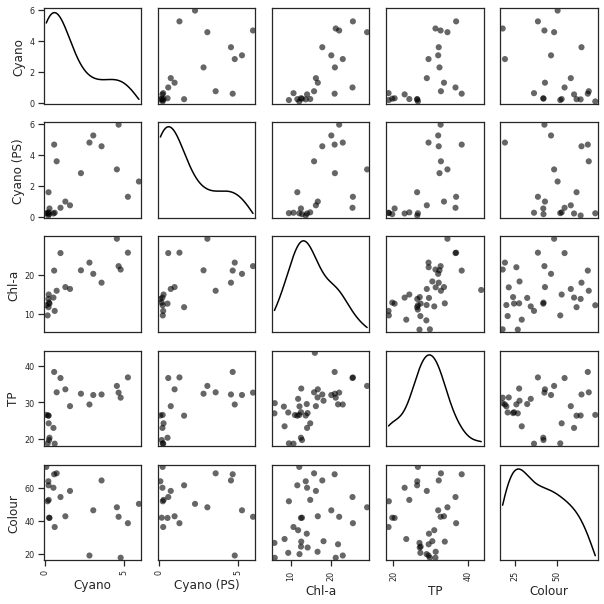

In [36]:
vars_for_scatterplot = ['CyanoBiovol',
                        'CyanoBiovol_prevSummer',
                        'chl-a_lake',
                        'TP_lake',
                        'colour_lake',
                       ]

plot_scattermatrix(season_var_df, vars_for_scatterplot, 'cyano')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


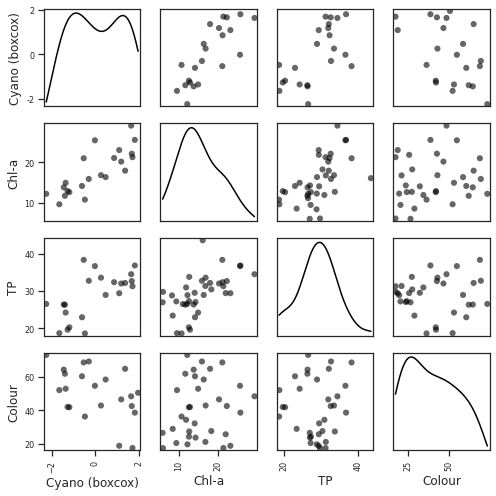

In [37]:
plot_df = season_var_df.copy()
plot_df["cyano_bxcx"] = boxcox(season_var_df["CyanoBiovol"].values, lmbda=0.1)

vars_for_scatterplot = ["cyano_bxcx", "chl-a_lake", "TP_lake", "colour_lake"]

plot_scattermatrix(plot_df, vars_for_scatterplot, "cyano_bxcx")

## Lake colour

In [38]:
# Drop all ecological-related stuff

cols_to_drop = [
    "CyanoBiovol",
    "CyanoBiovol_prevSummer",
    "Season",
    "TP_catch",
    "TP_lake",
    "TP_lake_prevSummer",
    "chl-a_lake",
    "chl-a_lake_prevSummer",
    "Temp_subzero",
]

season_df_lakeColour = season_var_df.drop(cols_to_drop, axis=1)
print(len(season_df_lakeColour))

# Drop any rows where response var is a NaN
season_df_lakeColour.dropna(subset=["colour_lake"], inplace=True)
print(len(season_df_lakeColour))
season_df_lakeColour.head()

39
35


,Pptn,Temp,Wind_speed,Q,colour_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,...,Wind_speed_lag1,Q_lag1,Rain_day_lag1,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,colour_lake_prevSummer,Temp_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1982-10-31,460.222077,13.213326,3.790761,38.953613,26.666667,64.0,18.0,20.0,53.0,81.0,...,3.383978,96.553901,61.0,10.0,47.0,81.0,70.0,42.0,NaN,12.574081
1983-10-31,465.471465,13.281862,4.259239,48.269174,17.625000,62.0,14.0,13.0,48.0,95.0,...,3.732597,124.071782,68.0,14.0,43.0,72.0,77.0,48.0,26.666667,13.213326
1985-10-31,548.106384,12.447242,3.633152,94.198550,34.404762,75.0,18.0,29.0,72.0,71.0,...,3.208840,107.977795,62.0,12.0,50.0,83.0,63.0,33.0,NaN,13.295250
1986-10-31,428.065964,12.187253,4.137500,NaN,27.472222,63.0,13.0,16.0,47.0,95.0,...,3.517680,27.737338,54.0,10.0,53.0,78.0,71.0,46.0,34.404762,12.447242
1987-10-31,711.386455,11.561030,3.466304,NaN,29.027778,86.0,21.0,26.0,68.0,63.0,...,3.419890,NaN,60.0,9.0,50.0,83.0,66.0,42.0,27.472222,12.187253


In [39]:
X = season_df_lakeColour.drop(['colour_lake'], axis=1)
y = season_df_lakeColour['colour_lake']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_colour_%s.csv' % met_source))

Wind_over_Q0.8           -0.468961
Wind_speed               -0.446417
Wind_over_Q0.6           -0.432186
Wind_over_Q0.6_lag1      -0.281966
Wind_over_Q0.8_lag1      -0.258542
Wind_speed_lag1          -0.162668
Wind_under_Q0.2_lag1     -0.161030
Rain_day_lag1             0.130335
Wind_under_Q0.2           0.144268
Wind_under_Q0.4_lag1      0.151604
Temp_lag1                 0.160472
Pptn_lag1                 0.220971
Pptn_intense_lag1         0.260855
Wind_under_Q0.4           0.282019
Q_lag1                    0.313415
Temp                      0.351692
Rain_day                  0.377725
Temp_prevSummer           0.417754
Q                         0.446138
Pptn_intense              0.446939
Pptn                      0.522042
colour_lake_prevSummer    0.856089
dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


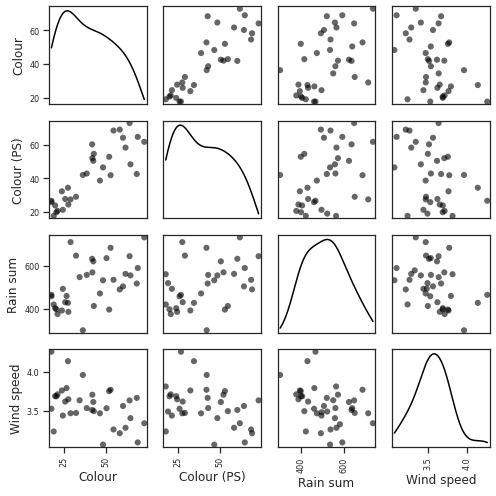

In [40]:
vars_for_scatterplot = [
    "colour_lake",
    "colour_lake_prevSummer",
    "Pptn",
    "Wind_speed"
]

plot_scattermatrix(season_var_df, vars_for_scatterplot, "colour")

# Write output csvs split by variable for use in feature importance analysis

In [41]:
basin = "Van2"
season_df_TP.to_csv(os.path.join(out_folder, 'dataMatrix_seasonal_TP_%s_%s.csv' % (season_slice, basin)), index_label='Date')
season_df_lake_chla.to_csv(os.path.join(out_folder, 'dataMatrix_seasonal_Chl-a_%s_%s.csv' % (season_slice, basin)), index_label='Date')
season_df_cyano.to_csv(os.path.join(out_folder, 'dataMatrix_seasonal_CyanoBiovol_%s_%s.csv' % (season_slice, basin)), index_label='Date')
season_df_lakeColour.to_csv(os.path.join(out_folder, 'dataMatrix_seasonal_colour_lake_%s_%s.csv' % (season_slice, basin)), index_label='Date')